# Classification of Covid from CT lung images built upon Visual Transformer with Linformer

Training & testing Visual Transformer on *Covid vs nonVovid Data*

* Data are collected from ICCV2021 Workshop MIA-COV19D - https://mlearn.lincoln.ac.uk/mia-cov19d/
* Base Code - Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch
#efficient-attention

In [1]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import torchvision.transforms.functional as TF
from torch.autograd import Variable
import torch.nn.functional as F
import io

#from vit_pytorch.efficient import ViT
from vit_pytorch.efficient import ViT
from vit_pytorch.deepvit import DeepViT

def resize2d(img, size):
    return F.adaptive_avg_pool2d(Variable(img),size).data


In [3]:
print(f"Torch: {torch.__version__}")

Torch: 1.8.1+cu102


In [4]:
# Training settings
batch_size = 64
epochs = 0 #40    # 0=no-training, only testing using trained model
lr = 3e-5
gamma = 0.7
seed = 42

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
device = 'cuda'

## Load Data

In [7]:
os.makedirs('data', exist_ok=True)

In [8]:
train_dir = 'data/train'
test_dir = 'data/test-seg-2'

In [9]:
#with zipfile.ZipFile('train.zip') as train_zip:
    #train_zip.extractall('data')
    
#with zipfile.ZipFile('test.zip') as test_zip:
    #test_zip.extractall('data')

In [10]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [11]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 150125
Test Data: 607


In [12]:
labels = [path.split('/')[-1].split('_')[0] for path in train_list]

## Random Plots

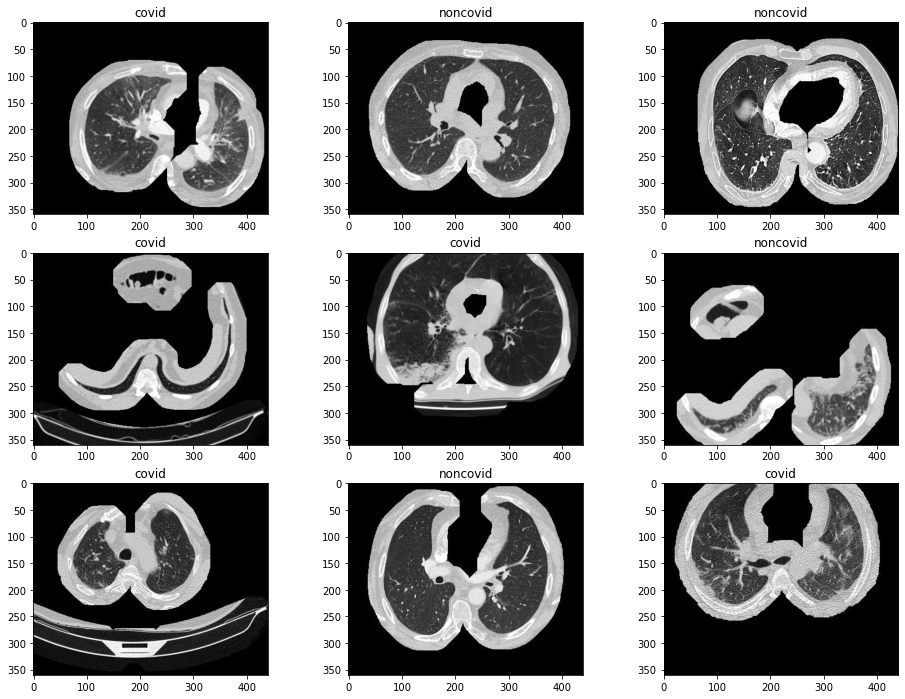

In [13]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [14]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [15]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 120100
Validation Data: 30025
Test Data: 607


## Image Augumentation

In [16]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [17]:
class CovidDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        #print('2d-img-shape=',img.size,type(img))
        img_transformed = self.transform(img)
        #print('2d-img-shape=',img_transformed.size(),type(img_transformed))
        label = img_path.split("/")[-1].split("_")[0]
        label = 1 if label == "covid" else 0
        return img_transformed, label


In [18]:
train_data = CovidDataset(train_list, transform=train_transforms)
valid_data = CovidDataset(valid_list, transform=test_transforms)
test_data = CovidDataset(test_list, transform=test_transforms)

In [19]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [20]:
print(len(train_data), len(train_loader))
a=train_data[0]
print('train-data-shape=', a[0].shape,a[1],type(a))

120100 1877
train-data-shape= torch.Size([3, 224, 224]) 0 <class 'tuple'>


In [21]:
print(len(valid_data), len(valid_loader))
print(len(test_data), len(test_loader))

30025 470
607 10


## Effecient Attention

### Linformer

In [22]:
efficient_transformer = Linformer(
    dim=1024,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [23]:
model = ViT(
    dim=1024,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)
## Loading pre-trained model based on all training-dataset
pretrained_net = torch.load('xg_vit_model_covid.pt')
model.load_state_dict(pretrained_net)


<All keys matched successfully>

### Training

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [25]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        # save a checkpoint

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data) 
            #print('val-data, max=',val_output.data[0], torch.max(val_output.data[0],0))
            val_loss = criterion(val_output, label)
            # print the resulrs
            cls = torch.max(val_output[0],0)
            cls = cls.indices
            #print('val-output',cls)
            
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    torch.save(model.state_dict(),'xg_vit_model_covid.pt')   #xg

    """
    # saving the validation data in a batch
with io.open('Vit-val-output-Ep80-TL.txt', 'w') as f:
    for i in range(len(label)):
        if cls>0:
            f.write("%s %s\n" % ('1', int(label[i].data)))
        else:
            f.write("%s %s\n" % ('0', int(label[i].data)))
    """
    

test-no= 607


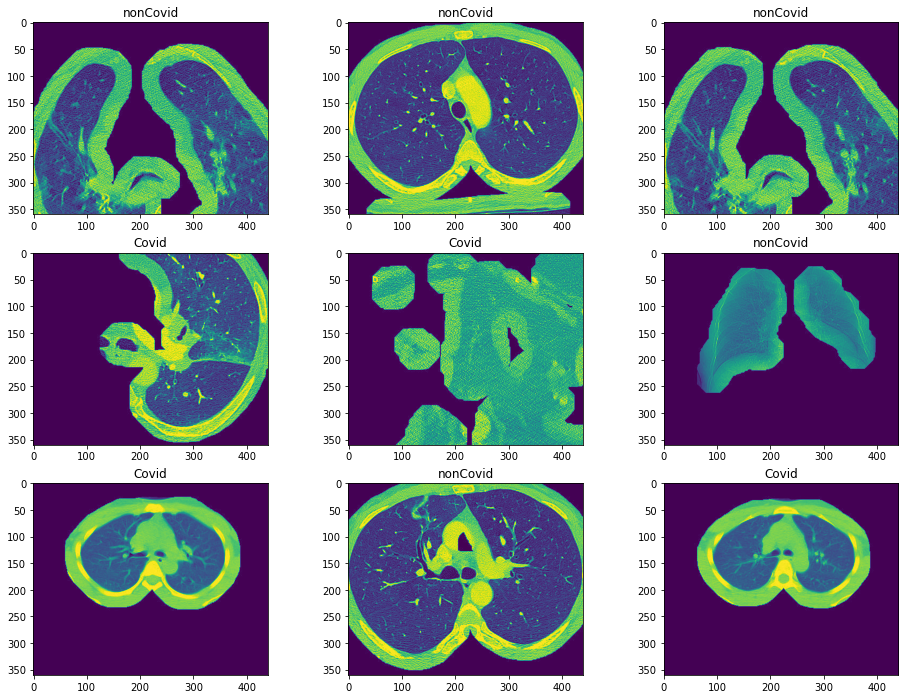

In [26]:
#Testing
"""
with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        #label = label.to(device)
        test_output = model(data) 
        #print('class=',torch.max(test_output[0],0))
        cls = torch.max(test_output[0],0)
        cls = cls.indices 
"""
## Newly added to check saved model
model = ViT(
    dim=1024,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)
pretrained_net = torch.load('xg_vit_model_covid.pt')
model.load_state_dict(pretrained_net)

# saving the predicted results for test data
test_no = len(test_list)   #for train samples
#train_no = len(train_list)
print('test-no=',test_no)
with io.open('Vit-test-final-Jun30-2.txt', 'w') as f:
    for idx in range(test_no):
       # img = Image.open(train_list[idx])
        img = Image.open(test_list[idx])
        img1 = TF.to_tensor(img)
        img2 = resize2d(img1,(224,224))
        x = torch.zeros(1,3,224,224)
        x[0] = img2
        out = x[0]
        out.unsqueeze_(0)
        out = out.to('cuda:0')
        model.to('cuda:0')
        # out.to(device)
        preds = model(out)
        #print('class=',torch.max(preds[0],0))
        cls = torch.max(preds[0],0)
        cls = cls.indices
       # if cls>0:
           # f.write("%s\t%s\n" % (test_list[idx],'1'))
       # else:
           # f.write("%s\t%s\n" % (test_list[idx],'0'))
        if cls>0:
            f.write("%s\t%s\n" % (test_list[idx],'1'))
        else:
            f.write("%s\t%s\n" % (test_list[idx],'0'))
    
#Working on test data
random_idx = np.random.randint(1, len(test_list),size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(test_list[idx])
    #img = Image.open(train_list[idx])
    #ax.set_title(labels[idx])
    ax.imshow(img)
    #print('img-name=,', test_list[idx])
    img1 = TF.to_tensor(img)
    img2 = resize2d(img1,(224,224))
    x = torch.zeros(1,3,224,224)
    x[0] = img2
    out = x[0]
    out.unsqueeze_(0)
    out = out.to('cuda:0')
    model.to('cuda:0')
    # out.to(device)
    preds = model(out)
    #print('class=',torch.max(preds[0],0))/
    cls = torch.max(preds[0],0)
    cls = cls.indices
    if cls>0:
        labels[idx] = 'Covid'
    else:
        labels[idx] = 'nonCovid'
    with io.open('Vit-test-9sample-Jun30-2.txt', 'a') as f:
        f.write("%s\t%s\n" % (test_list[idx], labels[idx]))
    ax.set_title(labels[idx])